### Check if configuration has been run already and change directory to repository root:

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datajoint as dj
import pandas as pd
import u19_pipeline.automatic_job.recording_handler as rec_handler
import u19_pipeline.automatic_job.recording_process_handler as rec_process_handler

from u19_pipeline import recording, lab

#import utility.dj_shortcuts as dj_short
#import utility.acquisition_pipeline_handler as aph
dj.__version__

Connecting alvaros@datajoint00.pni.princeton.edu:3306


'0.13.2'

In [3]:
from u19_pipeline.ephys_pipeline import ephys_element

In [5]:
cat_gt_params =  {
      "apfilter": ["biquad",2,300,0],
      "gfix": [0.40,0.10,0.02],
      "extras": ["prb_fld", "t_miss_ok", "ap", "gblcar", "out_prb_fld"]
   }
 
ephys_element.PreClusterParamSet.insert_new_params(
    precluster_method='catgt',
    paramset_idx=0,
    params=cat_gt_params,
    paramset_desc='Spike sorting using Kilosort2')
 
ephys_element.PreClusterParamSet()


paramset_idx,precluster_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,catgt,Spike sorting using Kilosort2,4271fe75-1732-5821-0070-45b4c286e867,=BLOB=


In [6]:
paramlist = {'precluster_param_list_id':0}
ephys_element.PreClusterParamList.insert1(paramlist)

paramorder = {
'precluster_param_list_id': 0,
'order_id': 1,
'paramset_idx': 0
}
ephys_element.PreClusterParamList.ParamOrder.insert1(paramorder)

ephys_element.PreClusterParamList.ParamOrder()


precluster_param_list_id,order_id Order of operations,paramset_idx
0,1,0


In [4]:
params = {
 "fs": 30000,
 "fshigh": 150,
 "minfr_goodchannels": 0.1,
 "Th": [10, 4],
 "lam": 10,
 "AUCsplit": 0.9,
 "minFR": 0.02,
 "momentum": [20, 400],
 "sigmaMask": 30,
 "ThPre": 8,
 "CAR": 1, 
 "spkTh": -6,
 "reorder": 1,
 "nskip": 25,
 "GPU": 1,
 "Nfilt": 1024,
 "nfilt_factor": 4,
 "ntbuff": 64,
 "NT": 32832,
 "whiteningRange": 32,
 "nSkipCov": 25,
 "scaleproc": 200,
 "nPCs": 3,
 "useRAM": 0,
 "trange": [0, 1000000000],
"NchanTOT": 384
}

ephys_element.ClusteringParamSet.insert_new_params(
    processing_method='kilosort2',
    paramset_idx=0,
    params=params,
    paramset_desc='Spike sorting using Kilosort2')
ephys_element.ClusteringParamSet()



paramset_idx,clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,kilosort2,Spike sorting using Kilosort2,b9e07e55-95ea-3463-a740-90291de41da6,=BLOB=


In [5]:
l = rec_handler.RecordingHandler.pipeline_handler_main()

function to apply: modality_preingestion
No SpikeGLX data found for session:{'recording_id': 39} - at ms81/ms81_M011/20211116/TowersTask_g0
this_modality_recording_table <class 'u19_pipeline.ephys_pipeline.EphysPipelineSession'>


In [16]:
l = rec_process_handler.RecProcessHandler.pipeline_handler_main()

scp u19_pipeline/automatic_job/ParameterFiles/preprocess_paramset_103.json alvaros@tigergpu.princeton.edu:/scratch/gpfs/BRAINCOGS/ParameterFiles/preprocess_paramset_103.json
0
scp u19_pipeline/automatic_job/ParameterFiles/process_paramset_103.json alvaros@tigergpu.princeton.edu:/scratch/gpfs/BRAINCOGS/ParameterFiles/process_paramset_103.json
0
scp u19_pipeline/automatic_job/SlurmFiles/slurm_real.slurm alvaros@tigergpu.princeton.edu:/scratch/gpfs/BRAINCOGS/SlurmFiles/slurm_real.slurm
0
['ssh', 'alvaros@tigergpu.princeton.edu', 'sbatch', "--export=recording_process_id=103,raw_data_directory='ms81/ms81_M011/20211120/TowersTask_g0/TowersTask_g0_imec3',processed_data_directory='ms81/ms81_M011/20211120/TowersTask_g0/TowersTask_g0_imec3/recording_process_id_103',repository_dir='/scratch/gpfs/BRAINCOGS/electorphysiology_processing/BrainCogsEphysSorters',process_script_path='main_script.py'", '/scratch/gpfs/BRAINCOGS/SlurmFiles/slurm_real.slurm']
stdout Submitted batch job 8489313

stderr 
p.re

In [8]:
keyo = dict()
keyo['preprocess_paramset_idx'] = 1
a = recording.PreprocessParamSet()
lo = a.get_preprocess_params(keyo)

keyo2 = dict()
keyo2['process_paramset_idx'] = 1
b = recording.ProcessParamSet()
lu = b.get_process_params(keyo2)



[[(array([[2.]]), array(['kilosort2'], dtype='<U9'))]]
<class 'datajoint.blob.MatStruct'>
soy ndarray
soy ndarray


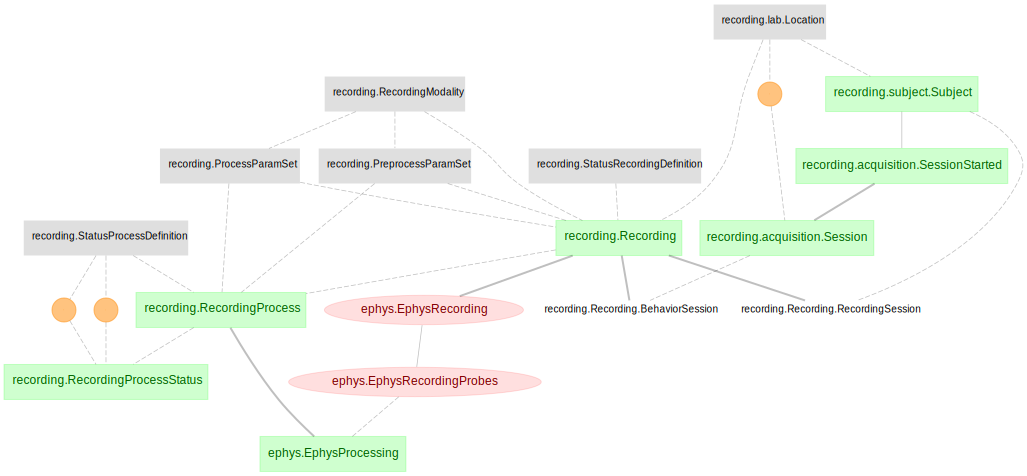

In [12]:
dj.ERD(recording) -1 + dj.ERD(ephys.EphysRecording) + dj.ERD(ephys.EphysProcessing)


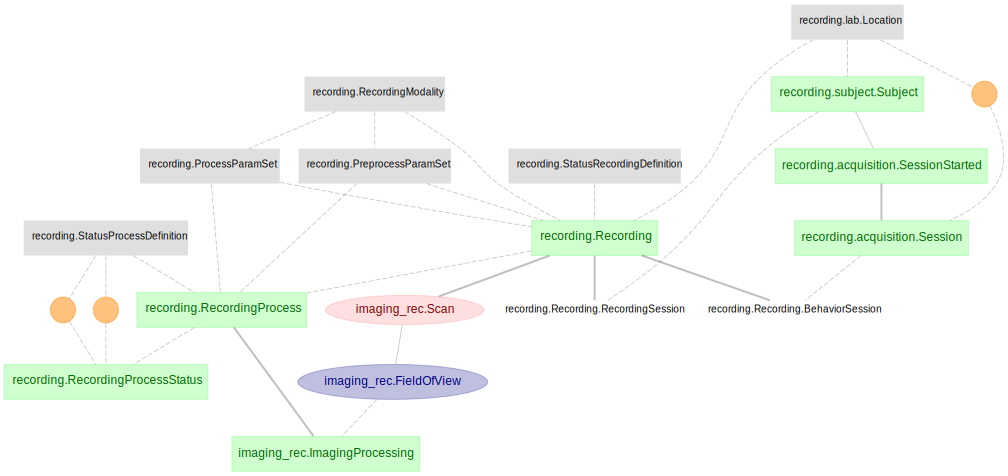

In [13]:
dj.ERD(recording) -1 + dj.ERD(imaging_rec.Scan) + dj.ERD(imaging_rec.ImagingProcessing) 
